<a href="https://colab.research.google.com/github/whpickle/Data-Science/blob/main/Stats%20140%20Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**STATS 140XP Project: Trump Tweets!**

Chelsea Chen, Helena Hu, Zoe Lu,
Wolfe Pickett, Sean Tjoa

Data Cleaning and Exploratory Data Analysis Notebook


# Data Cleaning

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

FILE_PATH = r'/content/drive/MyDrive/Stats 140XP Final Proj/Stats_140XP_Final_Project_Submission/Data and Code/'

# Mount Google Drive before running this code
df = pd.read_csv(FILE_PATH + 'tweets.csv')

Mounted at /content/drive


In [ ]:
# Replace string values of 'f' and 't' with 0 and 1 respectively
df[['isRetweet', 'isDeleted', 'isFlagged']] = df[['isRetweet', 'isDeleted', 'isFlagged']].replace({'f': 0, 't': 1})

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Strip leading and trailing whitespaces in tweets
df['text'] = df['text'].str.strip(" ")

# No missing values in our dataset
assert(np.sum(df.isna().sum()) == 0)

In [ ]:
# Investigating potential retweets (tweets starting w/ 'RT @')
retweet_mask = df['text'].str.startswith('RT @')
sus_retweet = (1 - df.loc[retweet_mask, "isRetweet"].mean()) * 100
print(f"{sus_retweet:.3}% of the data seem to be retweets but are not flagged as isRetweet")

1.31% of the data seem to be retweets but are not flagged as isRetweet


In [ ]:
# Remove all retweets from the dataset
df = df.loc[~retweet_mask]
df = df.loc[(df['isRetweet'] == 0)]

# Delete 'isRetweet' column since we removed all retweets
assert(df['isRetweet'].sum() == 0)
df = df.drop(columns='isRetweet')

In [ ]:
# Only keep tweets that were NOT deleted
df = df.loc[df['isDeleted'] == 0]
df = df.drop(columns='isDeleted')

### Cleaning Text Further

### VADER
- trained on twitter data that uses @anonymous to replace actual usernames and `http://url_removed/` for URLs linked
- https://vadersentiment.readthedocs.io/en/latest/pages/resource_description.html

In [ ]:
import nltk
import re

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def remove_unwanted(document):
    # remove user mentions
    document = re.sub("@[A-Za-z0-9_]+", "  @anonymous  ", document) # replacing @'s with @anonymous
    # remove URLS
    document = re.sub(r'http\S+', 'http://url_removed/', document) # replacing url's with url_removed
    # remove hashtags
    document = re.sub("#[A-Za-z0-9_]+","", document)
    # remove double spaces
    document = document.replace('  ', "")

    return document.strip()

In [ ]:
# Replace @usernames and URLs with anonymized versions
df['text'] = df['text'].transform(remove_unwanted)

In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.3 MB/s eta 0:00:00


In [ ]:
analyzer = SentimentIntensityAnalyzer()
df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df['text']]
df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df['text']]
df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df['text']]
df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df['text']]

In [ ]:
csv_name = 'final_tweets.csv'
df.to_csv(FILE_PATH + csv_name, index=False)

# Exploratory Data Analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

# Mount Google Drive before running this code
FILE_PATH = r'/content/drive/MyDrive/Stats 140XP Final Proj/Stats_140XP_Final_Project_Submission/Data and Code/'
df = pd.read_csv(FILE_PATH + 'final_tweets.csv')
df = df.dropna().reset_index(drop=True)

color_map = {'negative': '#EF553B', 'neutral': '#636EFA', 'positive': '#00CC96'}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def classify(score):
    if (score < -0.5):
        return 'negative'
    elif (score > 0.5):
        return 'positive'
    else:
        return 'neutral'
# assigning classifications
df['class'] = df['compound'].transform(classify)
# grouping by classifications
df['class'].value_counts()

neutral     22226
positive    17192
negative     6615
Name: class, dtype: int64

<ipython-input-14-b19c2e6682f0>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap='coolwarm')


<Axes: >

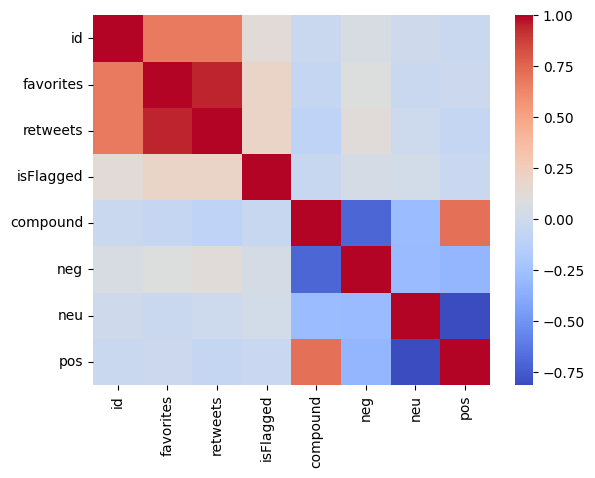

In [ ]:
# Correlation matrix
sns.heatmap(df.corr(), cmap='coolwarm')

In [ ]:
fig = px.histogram(df, x = 'compound', range_y = [0, 2500], nbins=97, color = 'class', color_discrete_map=color_map)
fig = fig.update_layout(xaxis_title="Compound Sentiment Score", yaxis_title = "Frequency",
                        title = "Frequency of Compound Sentiment Scores")
fig

In [ ]:
mask = df['retweets'] >= 500
fig = px.histogram(df.loc[mask], x = 'retweets', range_x = [500, 20000], nbins = 1000, color = 'class', color_discrete_map=color_map)
fig = fig.update_layout(xaxis_title="Number of Retweets", yaxis_title = "Frequency",
                        title = "Frequency of # Retweets by Sentiment")
fig

In [ ]:
mask = df['favorites'] < 2000
px.histogram(df.loc[mask], x = 'favorites', marginal="box",
             range_x = [0, 300], color = 'class', color_discrete_map=color_map,)

In [ ]:
mask = df['favorites'] >= 2000
df = df.rename(columns={'class': 'sentiment'})
fig = px.histogram(df.loc[mask], x = 'favorites', marginal="box",
             range_x = [0, 150000], nbins= 750,
             color = 'sentiment', color_discrete_map=color_map)
fig = fig.update_layout(xaxis_title="Number of Favorites", yaxis_title = "Frequency",
                        title = "Boxplot and Histogram of # Favorites by Sentiment")
fig.show()

In [ ]:
df['extreme'] = df['compound'].transform(lambda x: 'extreme' if abs(x) >= 0.5 else 'moderate')
df['extreme'].value_counts()

extreme     23809
moderate    22224
Name: extreme, dtype: int64

In [ ]:
extreme_colors = {'extreme': '#EF553B', 'moderate': '#636EFA'}
mask = df['favorites'] < 1500
df = df.rename(columns={'extreme': 'intensity'})
fig = px.histogram(df.loc[mask], x = 'favorites', marginal="box",
             range_x = [0, 1500],
             color = 'intensity', color_discrete_map=extreme_colors)
fig = fig.update_layout(xaxis_title="Number of Favorites", yaxis_title = "Frequency",
                        title = "Boxplot and Histogram of # Favorites by Intensity")
fig.show()

In [ ]:
extreme_colors = {'extreme': '#EF553B', 'moderate': '#636EFA'}
mask = df['favorites'] >= 1500
df = df.rename(columns={'extreme': 'intensity'})
fig = px.histogram(df.loc[mask], x = 'favorites', marginal="box",
             range_x = [0, 150000], range_y = [0, 3000],
             color = 'intensity', color_discrete_map=extreme_colors)
fig = fig.update_layout(xaxis_title="Number of Favorites", yaxis_title = "Frequency",
                        title = "Boxplot and Histogram of # Favorites by Intensity")
fig.show()

In [ ]:
date_df = df[['date', 'retweets', 'sentiment']]
date_df['date'] = pd.to_datetime(date_df['date'])

# Set 'date' as the index
date_df = date_df.set_index('date').sort_values('date')

# Compute the rolling average - change '3M' for a 3 months window
window_size = '90D'  # 3 months window
agg_df = date_df.groupby('sentiment')['retweets'].rolling(window_size).mean().reset_index(level=0)

# Plot using Plotly
fig = px.line(agg_df, y='retweets', color = 'sentiment',
              color_discrete_map=color_map, title='90-Day Moving Average of Retweets by Sentiment')
fig.show()


In [ ]:
date_df = df[['date', 'favorites', 'sentiment']]
date_df['date'] = pd.to_datetime(date_df['date'])

# Set 'date' as the index
date_df = date_df.set_index('date').sort_values('date')

# Compute the rolling average - change '3M' for a 3 months window
window_size = '90D'  # 3 months window
agg_df = date_df.groupby('sentiment')['favorites'].rolling(window_size).mean().reset_index(level=0)

# Plot using Plotly
fig = px.line(agg_df, y='favorites', color = 'sentiment',
              color_discrete_map=color_map, title='90-Day Moving Average of Favorites by Sentiment',
              range_x = [pd.to_datetime('January 2015'), agg_df.index.max()])
fig.show()


### Count of Total Tweets Over Time

In [ ]:
# creating date column of just month and year
df['date'] = pd.to_datetime(df['date'])
df['year'], df['month'] = df['date'].dt.year, df['date'].dt.month
df['DATE'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))

In [ ]:
counts_tweets = df.groupby('DATE')['text'].count()
counts_tweets

DATE
2009-05-01     21
2009-06-01     11
2009-07-01      5
2009-08-01      7
2009-09-01      3
             ... 
2020-09-01    708
2020-10-01    865
2020-11-01    585
2020-12-01    418
2021-01-01    104
Name: text, Length: 141, dtype: int64

In [ ]:
fig = px.line(counts_tweets, y='text')
fig.update_layout(
    title='Count of Tweets Per Month Over Time',
    xaxis_title="Date",
    yaxis_title="Count of Tweets",
)
fig.add_vline(x = '2015-06-16', line_dash = "dash", line_color = "red")
fig.add_vline(x = '2017-01-20', line_dash = "dash", line_color = "red")
fig.add_vline(x = '2021-01-20', line_dash = "dash", line_color = "red")

fig.show()

### Word Cloud

In [ ]:
import nltk
nltk.download('stopwords')

!pip install -U contractions --quiet

import re
import string
from nltk.corpus import stopwords
import contractions

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 6.6 MB/s eta 0:00:00


In [ ]:
stop_words = stopwords.words('english')

def custom_preprocessor(text):
    text = contractions.fix(text) #fix contractions
    text = text.lower() # convert to lowercase
    text = re.sub('\[.*?\]', '', text) # remove square brackets, including the brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove hyperlinks starting with 'http://' or 'https://' and links starting with 'www.'
    text = re.sub('<.*?>+', '', text) # remove HTML tags like <br>
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuation
    text = re.sub('\d+', '', text) # remove numbers
    text = re.sub('\n', '', text) # remove newline characters
    return text

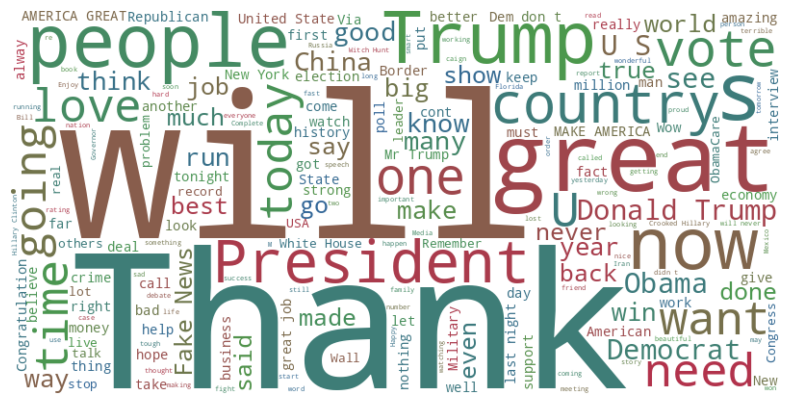

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Assuming 'df' is your DataFrame and 'text' is the column containing the text data
df['text'] = df['text'].astype(str)

# Remove 'anonymous' and 'url_removed' from the 'text' column
df['text'] = df['text'].str.replace('anonymous', '').str.replace('url_removed', '').str.replace('amp', '')

# apply preprocessing to the 'review' column
df['new_text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df['new_text'] = df['new_text'].apply(custom_preprocessor)

# Assuming 'text' is a string containing the text data
text = ' '.join(df['text'])

# Define a custom colormap with dark pastel colors
colors = [(0.2, 0.4, 0.6), (0.3, 0.6, 0.3), (0.7, 0.2, 0.3)]  # RGB values for blue, green, and red
custom_colormap = LinearSegmentedColormap.from_list('custom', colors, N=256)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=custom_colormap).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()